# Master jupyter notebook for LANL - SlimBros Team

Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data. Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

## Preliminaries
Let's import everything we need:

In [1]:
import os
import gc
import csv
import time
import random
import datetime
import warnings
import feather

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from catboost import CatBoostRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GridSearchCV, cross_val_score
from utils import generate_segment_start_ids, compare_methods
from features import gpi, create_all_features

#Configure the environment
%matplotlib inline
pd.options.display.precision = 15
warnings.filterwarnings('ignore')
random.seed(1013)

Load/compute the necessary features

In [2]:
compute_features = False 
# The computed features are saved in an hdf file along with the time_to_failure to 
# save the time spend reading the training data and the feature computation
#train_data_format = 'csv'
train_data_format = 'feather'

## Training data

In [3]:
def load_train_data(file_format):
    """Load the training dataset."""
    print(f"Loading data from {file_format} file:", end="")
    if file_format.lower() == 'feather':
        train_df = feather.read_dataframe('../input/train.feather')
    else:
        train_df = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16,
                                                            'time_to_failure': np.float32})
        feather.write_dataframe(train_df, '../input/train.feather')
    print("Done")
    return train_df

In [4]:
train = load_train_data(train_data_format)

Loading data from feather file:Done


## Feature generation
- Usual aggregations: mean, std, min and max;
- Average difference between the consequitive values in absolute and percent values;
- Absolute min and max vallues;
- Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
- Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
- Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
- Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
- Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [5]:
saved_files_present = (os.path.isfile('../tmp_results/X_tr.hdf') and 
                       os.path.isfile('../tmp_results/X_test.hdf') and 
                       os.path.isfile('../tmp_results/y_tr.hdf') )

In [6]:
if (not compute_features) and saved_files_present:
    print(f"Reading hdf files:", end="")
    X_tr = pd.read_hdf('../tmp_results/X_tr.hdf', 'data')
    X_test = pd.read_hdf('../tmp_results/X_test.hdf', 'data')
    y_tr = pd.read_hdf('../tmp_results/y_tr.hdf', 'data')  
    print("Done")
else:
    fs = 4000000 #Sampling frequency of the raw signal

    #Compute features for the training data
    segment_size = 150000
    segment_start_ids = generate_segment_start_ids('uniform_no_jump', segment_size, train)
    X_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64)
    y_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64, columns=['time_to_failure'])
    for idx in tqdm_notebook(range(len(segment_start_ids))):        
        seg_id = segment_start_ids[idx]
        seg = train.iloc[seg_id:seg_id + segment_size]
        create_all_features(idx, seg, X_tr, fs)
        y_tr.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    # Sanity check
    means_dict = {}
    for col in X_tr.columns:
        if X_tr[col].isnull().any():
            print(col)
            mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
            X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
            X_tr[col] = X_tr[col].fillna(mean_value)
            means_dict[col] = mean_value

    #Compute features for the test data
    submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
    X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
    for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
        seg = pd.read_csv('../input/test/' + seg_id + '.csv')
        create_all_features(seg_id, seg, X_test, fs)

    # Sanity check
    for col in X_test.columns:
        if X_test[col].isnull().any():
            X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
            X_test[col] = X_test[col].fillna(means_dict[col])
            
    X_tr.to_hdf('../tmp_results/X_tr.hdf', 'data')
    X_test.to_hdf('../tmp_results/X_test.hdf', 'data')
    y_tr.to_hdf('../tmp_results/y_tr.hdf', 'data')
    
    del segment_start_ids
    del means_dict
    del submission
    
    print("Done")

Reading hdf files:Done


## Scale data

In [7]:
alldata = pd.concat([X_tr, X_test])
scaler = StandardScaler()
alldata = pd.DataFrame(scaler.fit_transform(alldata), columns=alldata.columns)
X_train_scaled = alldata[:X_tr.shape[0]]
X_test_scaled = alldata[X_tr.shape[0]:]

## Building models

In [8]:
def train_model(X, X_test, y, folds, params=None, model_type='lgb',
                model=None, show_scatter=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    n_fold = folds.get_n_splits()
    
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if model_type == 'nn':
            dropout = params['dropout']
            num_layers = params['num_layers']
            num_neurons = params['num_neurons']
            activation_function = params['activation_function']
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(1024, input_dim=216, activation=activation_function))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.Dropout(dropout))
            for l in range(num_layers):
                model.add(tf.keras.layers.Dense(num_neurons, activation=activation_function))
                model.add(tf.keras.layers.BatchNormalization())
                model.add(tf.keras.layers.Dropout(dropout))
            model.add(tf.keras.layers.Dense(1))
            model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
            EPOCHS = 1000
            early_stop = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)

            history = model.fit(
                X_train,
                y_train,
                epochs=EPOCHS,
                validation_data = (X_valid, y_valid), 
                verbose=0,
                callbacks=[early_stop, PrintDot()])
            hist = pd.DataFrame(history.history)
            val_score = hist['val_mean_absolute_error'].iloc[-1]
            print(f'val_score={val_score}')
            plot_history(history)
        
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            y_pred = model.predict(X_test).reshape(-1,)

            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = 32)
            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric='mae',
                      verbose=10000,
                      early_stopping_rounds=2000)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data,
                              num_boost_round=20000,
                              evals=watchlist,
                              early_stopping_rounds=200,
                              verbose_eval=500,
                              params=params)

            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns),
                                   ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            y_pred = model.predict(X_test).reshape(-1,)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', task_type='GPU', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if model_type == 'gdi':
            y_pred_valid = gpi(X_valid).values
            y_pred = gpi(X_test).values
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = X.columns
            fold_importance['importance'] = model.feature_importances_
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    if show_scatter:
        fig, axis = plt.subplots(1, 2, figsize=(12,5))
        ax1, ax2 = axis
        ax1.set_xlabel('actual')
        ax1.set_ylabel('predicted')
        ax2.set_xlabel('train index')
        ax2.set_ylabel('time to failure')
        
        ax1.scatter(y, oof, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')

        ax2.plot(y, color='blue', label='y_train')
        ax2.plot(oof, color='orange')
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance['importance'] /= n_fold
        return oof, prediction, np.mean(scores), np.std(scores), feature_importance
    else:
        return oof, prediction, np.mean(scores), np.std(scores)

In [9]:
n_fold = 5
folds_models = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Let's try a few different models and submit the one with the best validation score. The predicted values in the following plots are using a out-of-fold scheme.

### LGBM (Gradient Boosting)
Gradient boosting that uses tree based learning algorithms.

Fold 0 started at Sun Apr 14 11:02:58 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1293]	training's l1: 1.84984	valid_1's l1: 2.02992
Fold 1 started at Sun Apr 14 11:03:02 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2388]	training's l1: 1.71373	valid_1's l1: 2.02458
Fold 2 started at Sun Apr 14 11:03:07 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1555]	training's l1: 1.78919	valid_1's l1: 2.12607
Fold 3 started at Sun Apr 14 11:03:11 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1101]	training's l1: 1.91743	valid_1's l1: 1.8859
Fold 4 started at Sun Apr 14 11:03:14 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[3138]	training's l1: 1.63143	valid_1's l1: 2.05338
CV mean score: 2.0240, std: 0.0

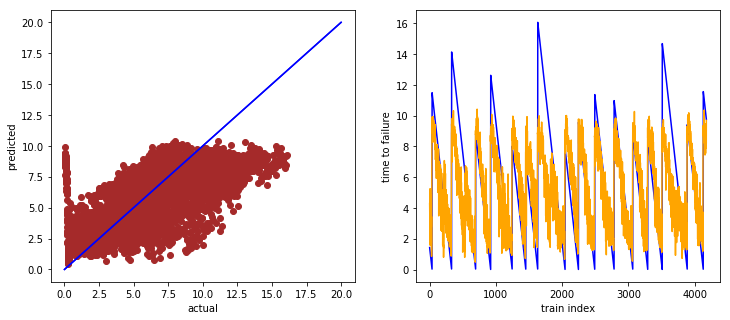

In [10]:
params_lgb = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 8, #54,
    'min_data_in_leaf': 100, #79,
    'max_depth': 6, #-1,
    'learning_rate': 0.01,
    'bagging_freq': 3, #5,
    'bagging_fraction': 0.7166666666666667, #0.8126672064208567,
    'bagging_seed': 11,
    'metric': 'mae',
    'reg_alpha': 0.19444444444444445, #0.1302650970728192,
    'reg_lambda': 0.8555555555555555 #0.3603427518866501
}
oof_lgb, prediction_lgb, score_mean_lgb, score_std_lgb, feature_importance = train_model(X=X_train_scaled,
                                                                                         X_test=X_test_scaled,
                                                                                         y=y_tr,
                                                                                         folds=folds_models,
                                                                                         params=params_lgb,
                                                                                         model_type='lgb',
                                                                                         show_scatter=True)

### XGBoost (Gradient Boosting)
Gradient boosting that uses tree based learning algorithms.

Fold 0 started at Sun Apr 14 11:03:20 2019
[0]	train-mae:5.14376	valid_data-mae:5.12501
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[251]	train-mae:1.5739	valid_data-mae:2.04671

Fold 1 started at Sun Apr 14 11:03:22 2019
[0]	train-mae:5.16538	valid_data-mae:5.03916
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[255]	train-mae:1.57789	valid_data-mae:2.03345

Fold 2 started at Sun Apr 14 11:03:23 2019
[0]	train-mae:5.11566	valid_data-mae:5.24084
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[500]	train-mae:1.2721	valid_data-mae:2.15012
Stopping. Best iteration:
[347]	train-mae:1.42966	valid_data-mae:2.14315

Fold 3 

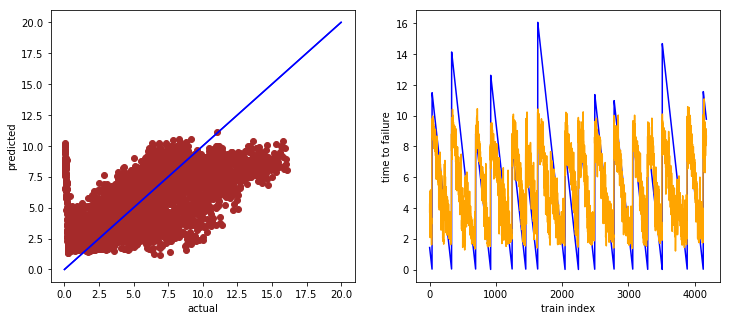

In [11]:
params_xgb = {
    'eta': 0.01, #Andrew uses 0.03
    'max_depth': 6, #Andrew uses 10
    'subsample': 0.5, #Andrew uses 0.9
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
} # CV mean score: 2.0801, std: 0.0711.
oof_xgb, prediction_xgb, score_mean_xgb, score_std_xgb = train_model(X=X_train_scaled,
                                                                     X_test=X_test_scaled,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=params_xgb,
                                                                     model_type='xgb',
                                                                     show_scatter=True)

### SVM
Similar to NuSVC, for regression, uses a parameter nu to control the number of support vectors. However, unlike NuSVC, where nu replaces C, here nu replaces the parameter epsilon of epsilon-SVR.

Fold 0 started at Sun Apr 14 11:03:29 2019
Fold 0. MAE: 2.0527.

Fold 1 started at Sun Apr 14 11:03:32 2019
Fold 1. MAE: 2.1044.

Fold 2 started at Sun Apr 14 11:03:35 2019
Fold 2. MAE: 2.1487.

Fold 3 started at Sun Apr 14 11:03:38 2019
Fold 3. MAE: 1.9616.

Fold 4 started at Sun Apr 14 11:03:40 2019
Fold 4. MAE: 2.0749.

CV mean score: 2.0685, std: 0.0624.


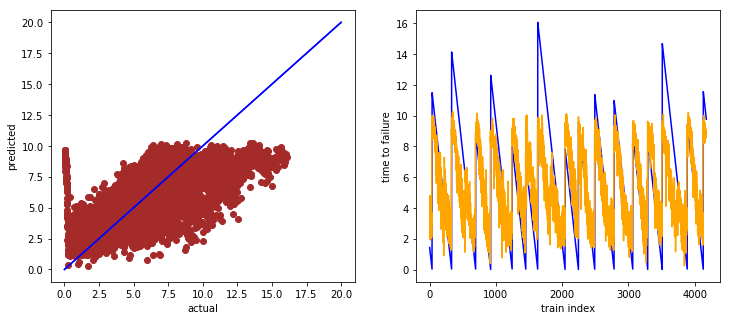

In [12]:
#model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01) #original values
model = NuSVR(gamma='scale', nu=0.63, C=0.4469387755102041, tol=0.01)
oof_svr, prediction_svr, score_mean_svr, score_std_svr = train_model(X=X_train_scaled,
                                                                     X_test=X_test_scaled,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=None,
                                                                     model_type='sklearn',
                                                                     model=model,
                                                                     show_scatter=True)
del model

### Catboost

Fold 0 started at Sun Apr 14 11:03:43 2019
Fold 1 started at Sun Apr 14 11:07:15 2019
Fold 2 started at Sun Apr 14 11:10:39 2019
Fold 3 started at Sun Apr 14 11:14:12 2019
Fold 4 started at Sun Apr 14 11:17:31 2019
CV mean score: 2.0289, std: 0.0771.


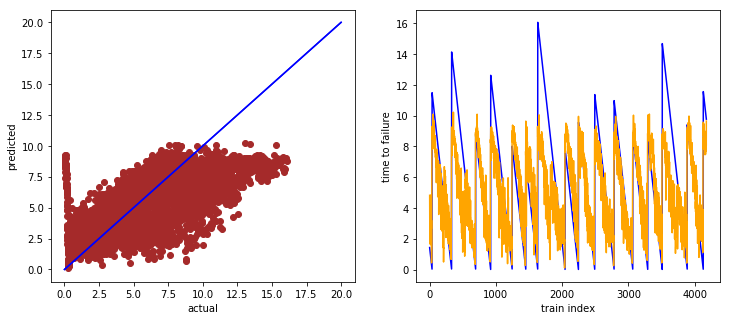

In [13]:
params_cat = {
    'loss_function':'MAE'
}
oof_cat, prediction_cat, score_mean_cat, score_std_cat = train_model(X=X_train_scaled,
                                                                     X_test=X_test_scaled,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=params_cat,
                                                                     model_type='cat',
                                                                     show_scatter=True)

### Kernel Ridge
This model combines regularized linear regression with a given kernel (radial basis in this case).

Fold 0 started at Sun Apr 14 11:20:56 2019
Fold 0. MAE: 2.0739.

Fold 1 started at Sun Apr 14 11:20:57 2019
Fold 1. MAE: 2.0739.

Fold 2 started at Sun Apr 14 11:20:58 2019
Fold 2. MAE: 2.1611.

Fold 3 started at Sun Apr 14 11:20:58 2019
Fold 3. MAE: 1.9480.

Fold 4 started at Sun Apr 14 11:20:59 2019
Fold 4. MAE: 2.1000.

CV mean score: 2.0714, std: 0.0694.


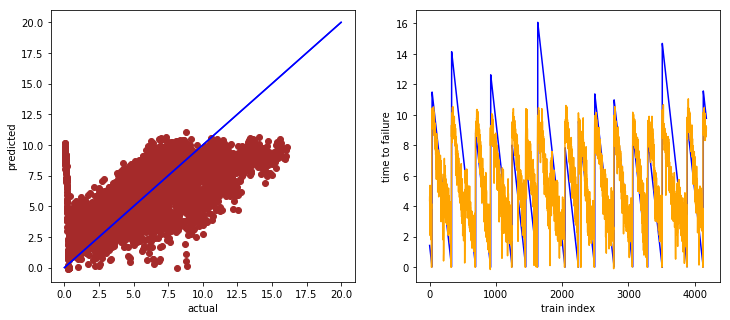

In [14]:
#model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01) #Original parameters
model = KernelRidge(kernel='rbf', alpha=2.4497346938775513, gamma=0.0018461224489795917)
oof_r, prediction_r, score_mean_r, score_std_r = train_model(X=X_train_scaled,
                                                             X_test=X_test_scaled,
                                                             y=y_tr,
                                                             folds=folds_models,
                                                             params=None,
                                                             model_type='sklearn',
                                                             model=model,
                                                             show_scatter=True)
del model

### Genetic Program Model
Genetic programming model from https://www.kaggle.com/scirpus/andrews-script-plus-a-genetic-program-model

Fold 0 started at Sun Apr 14 11:21:00 2019
Fold 1 started at Sun Apr 14 11:21:00 2019
Fold 2 started at Sun Apr 14 11:21:01 2019
Fold 3 started at Sun Apr 14 11:21:02 2019
Fold 4 started at Sun Apr 14 11:21:03 2019
CV mean score: 1.8985, std: 0.0738.


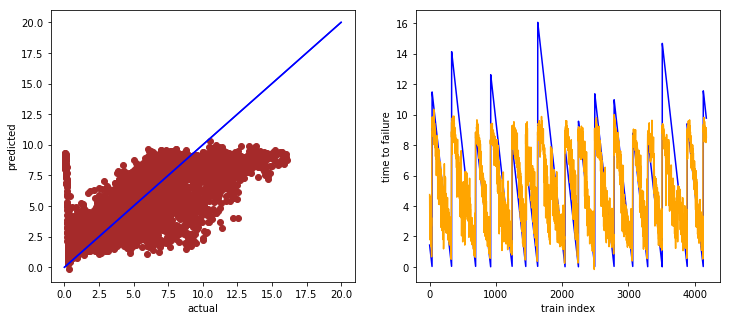

In [15]:
# There are no tuning here. We took at as face value.
oof_gdi, prediction_gdi, score_mean_gdi, score_std_gdi = train_model(X=X_train_scaled,
                                                                     X_test=X_test_scaled,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     model_type='gdi',
                                                                     show_scatter=True)

### Random Forest
This regressor fits many decision trees with different subsets of the original data and average the predictions between them.

Fold 0 started at Sun Apr 14 11:21:04 2019
Fold 0. MAE: 2.0621.

Fold 1 started at Sun Apr 14 11:21:07 2019
Fold 1. MAE: 2.0709.

Fold 2 started at Sun Apr 14 11:21:10 2019
Fold 2. MAE: 2.1248.

Fold 3 started at Sun Apr 14 11:21:13 2019
Fold 3. MAE: 1.9362.

Fold 4 started at Sun Apr 14 11:21:15 2019
Fold 4. MAE: 2.0856.

CV mean score: 2.0559, std: 0.0636.


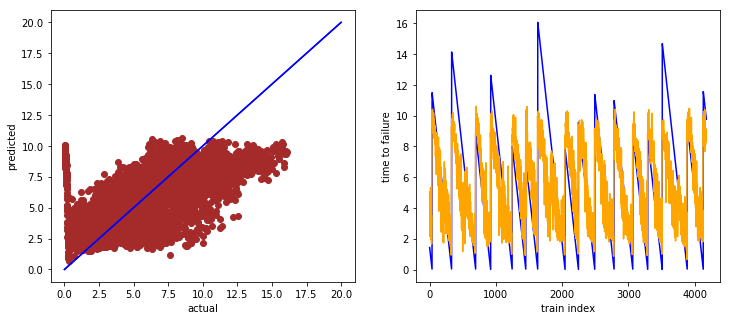

In [16]:
params_rf = {
    'max_depth': 12, #8,
    'max_features': 'log2', #'auto',
    'min_samples_leaf': 2,
    'min_samples_split': 4 #6
} #CV mean score: 2.0448, std: 0.0793.
model = RandomForestRegressor(criterion='mae', n_estimators=200, n_jobs=-1, **params_rf)
oof_rf, prediction_rf, score_mean_rf, score_std_rf = train_model(X=X_train_scaled,
                                                                 X_test=X_test_scaled,
                                                                 y=y_tr,
                                                                 folds=folds_models,
                                                                 params=params_rf,
                                                                 model_type='sklearn',
                                                                 model=model,
                                                                 show_scatter=True)
del model

### Extremely Randomized Trees


Fold 0 started at Sun Apr 14 11:21:19 2019
Fold 0. MAE: 2.0338.

Fold 1 started at Sun Apr 14 11:21:22 2019
Fold 1. MAE: 2.0807.

Fold 2 started at Sun Apr 14 11:21:26 2019
Fold 2. MAE: 2.1116.

Fold 3 started at Sun Apr 14 11:21:29 2019
Fold 3. MAE: 1.9191.

Fold 4 started at Sun Apr 14 11:21:33 2019
Fold 4. MAE: 2.0785.

CV mean score: 2.0447, std: 0.0676.


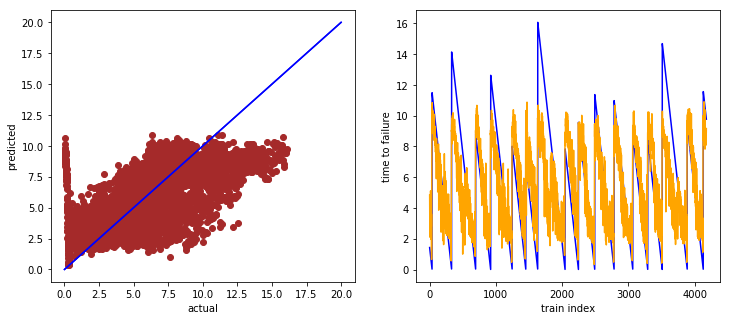

In [17]:
params_ex = {
    'max_depth': 12,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 4
}
model = ExtraTreesRegressor(criterion='mae', n_estimators=200, n_jobs=-1, **params_ex)
oof_ex, prediction_ex, score_mean_ex, score_std_ex = train_model(X=X_train_scaled,
                                                                 X_test=X_test_scaled,
                                                                 y=y_tr,
                                                                 folds=folds_models,
                                                                 params=params_ex,
                                                                 model_type='sklearn',
                                                                 model=model,
                                                                 show_scatter=True)
del model

### Ada Boost
AdaBoost begins by fitting a base estimator on the original dataset and then fits additional copies on the same dataset. At each iteration (estimator), the weights of instances are adjusted according to the error of the last prediction. It's similar to the next model, but gradient boosting fits additional estimator copies on the current error and not on the original dataset.

Fold 0 started at Sun Apr 14 11:21:37 2019
Fold 0. MAE: 2.0791.

Fold 1 started at Sun Apr 14 11:22:46 2019
Fold 1. MAE: 2.0721.

Fold 2 started at Sun Apr 14 11:23:49 2019
Fold 2. MAE: 2.1622.

Fold 3 started at Sun Apr 14 11:24:52 2019
Fold 3. MAE: 1.9486.

Fold 4 started at Sun Apr 14 11:25:57 2019
Fold 4. MAE: 2.0998.

CV mean score: 2.0724, std: 0.0696.


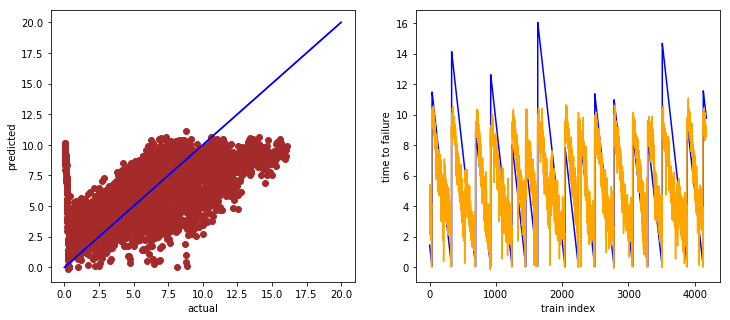

In [18]:
params_ada = {
    'learning_rate': 0.001
}
base = KernelRidge(kernel='rbf', alpha=2.4497346938775513, gamma=0.0018461224489795917)
model = AdaBoostRegressor(base_estimator=base, n_estimators=100, **params_ada)
oof_ada, prediction_ada, score_mean_ada, score_std_ada = train_model(X=X_train_scaled,
                                                                     X_test=X_test_scaled,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=params_ada,
                                                                     model_type='sklearn',
                                                                     model=model,
                                                                     show_scatter=True)
del base
del model

### Neural Network

Helper functions

In [10]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        else:
            print('.', end='')

In [11]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    #plt.ylim([0,5])
    plt.legend()
    plt.grid()
    plt.show()

#### FC model (all_features)x256x1
The following model is a fully-connected neural network that uses all the features from the training set.

Structure:
- Input layer
- Fully connected layer of 256 neurons with tanh activation
- Output layer with linear activation
![(all_features)x256x1 model](./figures/all_featuresx256x1.png)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

...................................................................................................
...................................................................................................
.................................................val_score=2.8655319213867188


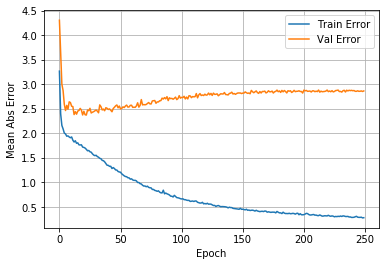

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               55552     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 55,809
Trainable params: 55,809
Non-trainable params: 0
_________________________________________________________________
None


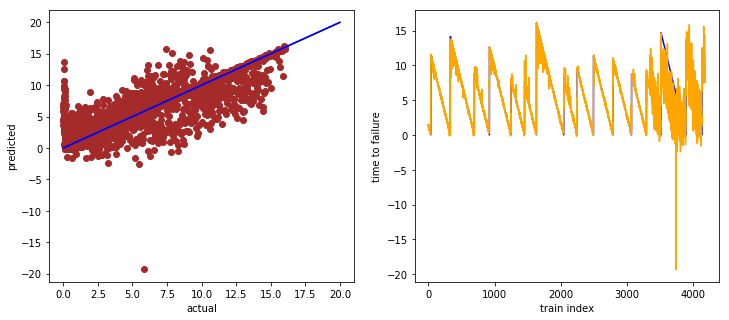

In [12]:
activation_function = 'tanh'
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,
                                input_dim=X_train_scaled.shape[-1],
                                activation=activation_function))
model.add(tf.keras.layers.Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Adam(lr = 0.001, decay = 0.001 / 32)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])
EPOCHS = 250
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)
history = model.fit(
    X_train_scaled,
    y_tr,
    validation_split=0.2,
    epochs=EPOCHS,
    shuffle=True,
    verbose=0,
    callbacks=[early_stop, PrintDot()])
hist = pd.DataFrame(history.history)
val_score = hist['val_mean_absolute_error'].iloc[-1]

#Show results
print(f'val_score={val_score}')
plot_history(history)

y_pred = model.predict(X_train_scaled).reshape(-1,)
fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y_tr, y_pred, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_tr, color='blue', label='y_train')
ax2.plot(y_pred, color='orange')

#Save results
print(model.summary())
tf.keras.utils.plot_model(model, to_file='./figures/all_featuresx256x1.png', show_shapes=True, show_layer_names=True)

# Housekeeping
del model
tf.keras.backend.clear_session()

#### Ensemble NN model with FC 5x256x1 networks
The following model is an ensemble of small fully-connected neural networks. Each small neural network uses 5 features from the training set. The features are selected from exhaustive search using the script `feature_search_nn_5x256x1.py`.

Structure of each NN:
- Input layer
- Fully connected layer of 5 neurons with tanh activation
- Output layer with leaky ReLU
![5x256x1.png model](./figures/5x256x1.png)

Ensemble:
- Uses `num_single_nets` small networks
- Weighted average using the inverse of the validation scores (`val_score`)

In [13]:
out_path = '../output/features_list_gdi_nn_5x256x1/'
all_files = [f for f in os.listdir(out_path) if os.path.isfile(os.path.join(out_path, f))]
li = []
for f in all_files:
    df = pd.read_csv(os.path.join(out_path, f), index_col=None, header=0)
    li.append(df)
results_nn = pd.concat(li, axis=0, ignore_index=True)

In [14]:
num_single_nets = 3
results_nn_sorted = results_nn.sort_values(by=['val_score']).iloc[0:num_single_nets]

Building FC-NN 0. Features considered:
['abs_max_roll_mean_100', 'ave_roll_std_10', 'q95_roll_std_100', 'q05_roll_std_1000', 'q05_roll_std_10']

...................................................................................................
...................................................................................................val_score=2.3475546836853027
Building FC-NN 1. Features considered:
['q99_roll_std_100', 'MA_400MA_BB_high_mean', 'q99_roll_mean_10', 'Hilbert_mean', 'q05_roll_std_10']

...................................................................................................
...................................................................................................val_score=2.3743813037872314
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 6         
____________________________________________________________

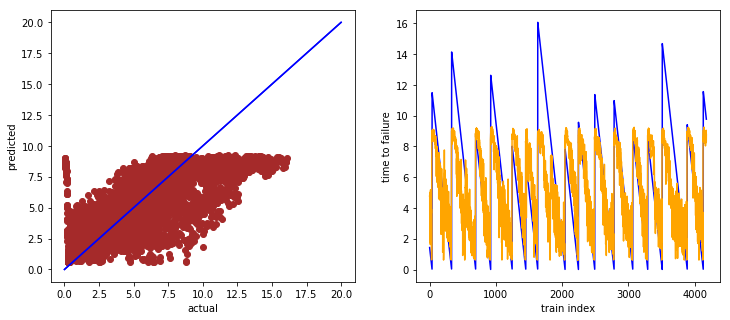

In [15]:
predictions = np.zeros((num_single_nets,len(X_test_scaled)))
oofs = np.zeros((num_single_nets,len(X_train_scaled)))
scores = []
for i in tqdm_notebook(range(num_single_nets)):
    nn_features_list = [results_nn_sorted['f1'].iloc[i],
                        results_nn_sorted['f2'].iloc[i],
                        results_nn_sorted['f3'].iloc[i],
                        results_nn_sorted['f4'].iloc[i],
                        results_nn_sorted['f5'].iloc[i]]
    X_train_nn = X_train_scaled[nn_features_list]
    X_test_nn = X_test_scaled[nn_features_list]
    print(f"Building FC-NN {i}. Features considered:")  
    print(nn_features_list)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1,
                                    input_dim=X_train_nn.shape[-1],
                                    activation='tanh'))
    model.add(tf.keras.layers.Dense(1,
                                    activation=tf.keras.layers.LeakyReLU()))

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    EPOCHS = 200
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)
    history = model.fit(
        X_train_nn,
        y_tr,
        validation_split=0.2,
        epochs=EPOCHS,
        shuffle=True,
        verbose=0,
        callbacks=[early_stop, PrintDot()])
    hist = pd.DataFrame(history.history)
    val_score = hist['val_mean_absolute_error'].iloc[-1]
    scores.append(val_score)
    print(f'val_score={val_score}')

    oofs[i] = model.predict(X_train_nn).reshape(-1,)
    predictions[i] = model.predict(X_test_nn).reshape(-1,)
    
    #Save results
    if i==1:
        print(model.summary())
        tf.keras.utils.plot_model(model, to_file='./figures/5x256x1.png', show_shapes=True, show_layer_names=True)

    #Housekeeping
    del model
    tf.keras.backend.clear_session()
    
#Combine estimations
model_confidence = 1/np.array(scores)
model_confidence /= np.sum(model_confidence)
prediction = np.average(predictions.T, weights=model_confidence, axis=1)
oof = np.average(oofs.T, weights=model_confidence, axis=1)

#Show results
fig, axis = plt.subplots(1, 2, figsize=(12,5))
ax1, ax2 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax1.scatter(y_tr, oof, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_tr, color='blue', label='y_train')
ax2.plot(oof, color='orange')
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

In [ ]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction
submission.to_csv('../output/submission_nn_5x1x1_average.csv')

#### DNN model

In [ ]:
params_nn = {
    'dropout': 0.70,
    'num_layers': 2,
    'num_neurons': 90,
    'activation_function': 'tanh'
}
oof_dnn, prediction_dnn, score_mean_dnn, score_std_dnn = train_model(X=X_train_scaled,
                                                                     X_test=X_test_scaled,
                                                                     y=y_tr,
                                                                     folds=folds_models,
                                                                     params=params_dnn,
                                                                     model_type='nn',
                                                                     show_scatter=True)

## Stacking and blending
And now let's try stacking :) We can use the same function for it.

In [19]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_r,
                         oof_cat, oof_gdi, oof_rf, oof_ex,
                         oof_ada]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'r', 'cat', 'gdi', 'rf', 'ex', 'ada'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_r,
                        prediction_cat, prediction_gdi, prediction_rf, prediction_ex,
                        prediction_ada]).transpose()
test_stack = pd.DataFrame(test_stack)

In [20]:
params_lgb_stack = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 8, #54,
    'min_data_in_leaf': 100, #79,
    'max_depth': 5, #-1,
    'learning_rate': 0.01, #0.01,
    'bagging_freq': 5, #5,
    'bagging_fraction': 0.7555555555555555, #0.8126672064208567,
    'bagging_seed': 11,
    'metric': 'mae',
    'reg_alpha': 0.95, #0.1302650970728192,
    'reg_lambda': 0.19444444444444445 #0.3603427518866501
}
oof_lgb_stack, prediction_lgb_stack, score_mean_lgb_stack, score_std_lgb_stack, feature_importance_lgb_stack = train_model(
    X=train_stack,
    X_test=test_stack,
    y=y_tr,
    folds=folds_models,
    params=params_lgb_stack,
    model_type='lgb')

Fold 0 started at Sun Apr 14 11:27:24 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1595]	training's l1: 1.77909	valid_1's l1: 1.87776
Fold 1 started at Sun Apr 14 11:27:26 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2395]	training's l1: 1.75837	valid_1's l1: 1.86042
Fold 2 started at Sun Apr 14 11:27:28 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[2035]	training's l1: 1.74091	valid_1's l1: 1.95032
Fold 3 started at Sun Apr 14 11:27:30 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1270]	training's l1: 1.82815	valid_1's l1: 1.73683
Fold 4 started at Sun Apr 14 11:27:32 2019
Training until validation scores don't improve for 2000 rounds.
Early stopping, best iteration is:
[1854]	training's l1: 1.77106	valid_1's l1: 1.87657
CV mean score: 1.8604, std: 0.

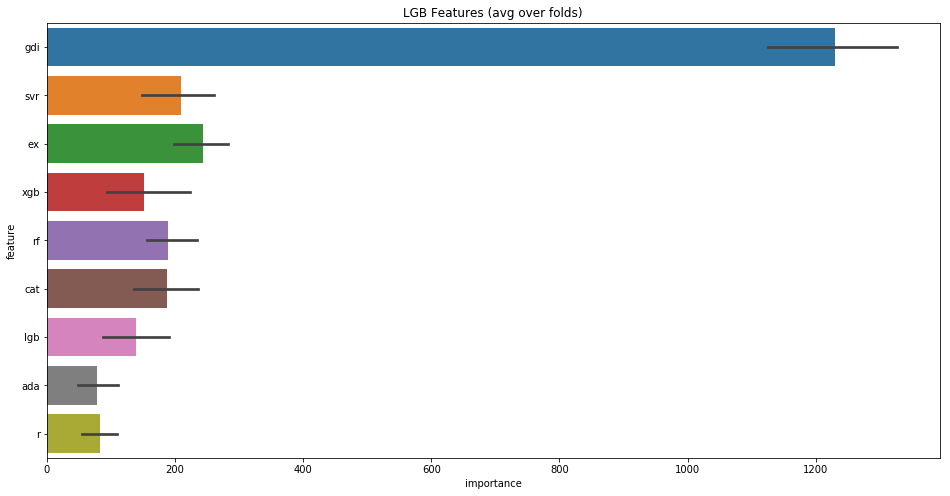

In [21]:
cols = feature_importance_lgb_stack[['feature', 'importance']].groupby('feature').mean().sort_values(
    by='importance', ascending=False).index
best_features = feature_importance_lgb_stack.loc[feature_importance_lgb_stack.feature.isin(cols)]
plt.figure(figsize=(16, 8));
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False));
plt.title('LGB Features (avg over folds)');

In [22]:
oof_blend = (oof_lgb + oof_xgb + oof_svr + oof_r + oof_cat + oof_gdi + oof_rf + oof_ex + oof_ada) / 9
prediction_blend = (prediction_lgb + prediction_xgb + prediction_svr 
                    + prediction_cat + prediction_r + prediction_gdi
                    + prediction_rf + prediction_ex + prediction_ada) / 9
score_mean_blend = (score_mean_lgb + score_mean_xgb + score_mean_svr + score_mean_cat
                    + score_mean_r + score_mean_gdi + score_mean_rf + score_mean_ex + score_mean_ada) / 9
score_std_blend = (score_std_lgb + score_std_xgb + score_std_svr + score_std_cat
                    + score_std_r + score_std_gdi + score_std_rf + score_std_ex + score_std_ada) / 9

### Submissions

In [23]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
my_methods = ['lgb', 'xgb', 'svr', 'r', 'cat', 'gdi', 'rf', 'ex', 'ada', 'lgb_stack', 'blend']

In [24]:
for method in my_methods:
    submission['time_to_failure'] = globals()['prediction_' + method]
    submission.to_csv('../output/submission_' + method + '.csv')
    evaluation.loc[method, 'mean'] = globals()['score_mean_' + method]
    evaluation.loc[method, 'std'] = globals()['score_std_' + method]
evaluation.to_csv(f"../output/evaluation_{str(datetime.datetime.now())}.csv")

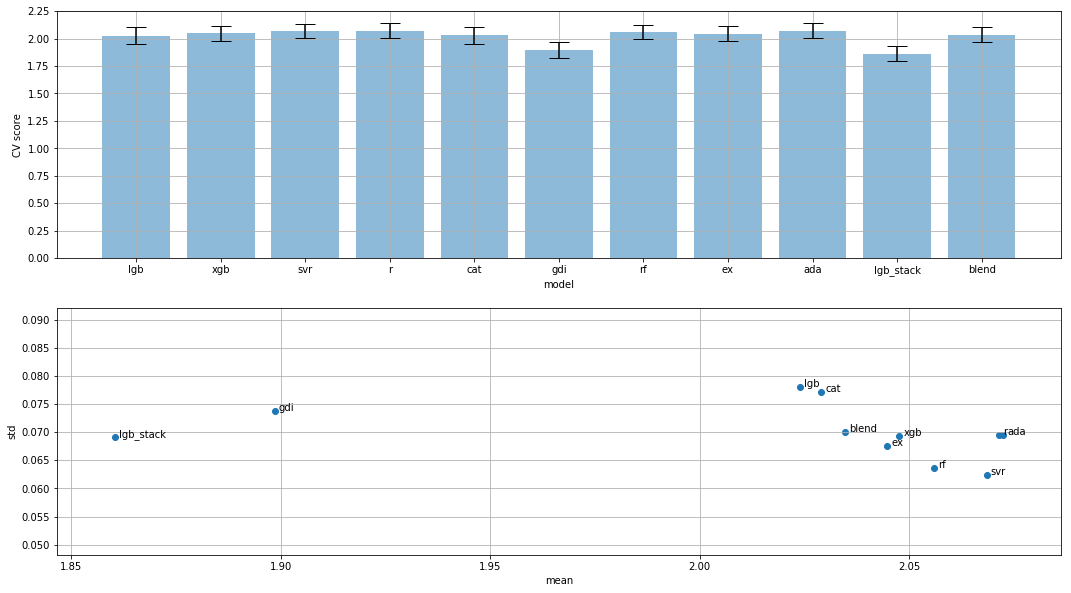

In [25]:
compare_methods(evaluation)